In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_data = pd.read_csv("./data/processed_train.csv", delimiter = ',')
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,hours-per-week_cat,workclass_cat,education_cat,marital-status_cat,occupation_cat,relationship_cat,race_cat,sex_cat,native-country_cat,salary_label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,2,5,9,4,0,1,4,1,38,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,1,4,9,2,3,0,4,1,38,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,2,2,11,0,5,1,4,1,38,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,2,2,1,2,5,0,2,1,38,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,2,2,9,2,9,5,2,0,4,0


In [3]:
test_data = pd.read_csv("./data/processed_test.csv", delimiter = ',')
test_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,hours-per-week_cat,workclass_cat,education_cat,marital-status_cat,occupation_cat,relationship_cat,race_cat,sex_cat,native-country_cat,salary_label
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,...,2,2,1,4,6,3,2,1,37,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,3,2,11,2,4,0,4,1,37,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,...,2,1,7,2,10,0,4,1,37,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,2,2,15,2,6,0,2,1,37,1
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,...,2,2,0,4,7,1,4,1,37,0


In [4]:
print(f'Our proccesed train data has {len(train_data.columns)} columns.')
print(f'Columns: {train_data.columns}')

Our proccesed train data has 28 columns.
Columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary', 'age_cat', 'capital-gain_cat', 'capital-loss_cat',
       'hours-per-week_cat', 'workclass_cat', 'education_cat',
       'marital-status_cat', 'occupation_cat', 'relationship_cat', 'race_cat',
       'sex_cat', 'native-country_cat', 'salary_label'],
      dtype='object')


In [5]:
def train_xgboost(X_train, y_train, X_val, y_val):
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # show importances
    importances = model.feature_importances_
    importances = pd.Series(importances, index = columns_for_training)
    print("==== IMPORTANCES ====\n")
    print(importances)

    predictions = model.predict(X_val)
    
    # plot confusion matrix
    cm = confusion_matrix(y_val, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    print("\n==== CONFUSION MATRIX ====")
    disp.plot()
    plt.show()
    
    # show classification report
    print("\n==== CLASSIFICATION REPORT ====\n")
    print(classification_report(y_val, predictions))
    
    return model, predictions
    

In [6]:
def compute_result(y, predictions):   
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions)
    rec = recall_score(y, predictions)
    f1 = f1_score(y, predictions)

    result = pd.DataFrame({'Model': ['XGBoost']})

    result['accuracy'] = acc
    result['precision'] = prec
    result['recall'] = rec
    result['f1'] = f1

    return result

In [7]:
def plot_features(model, X_val):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
    plt.title('Feature Importance')

## First we test the model using most of the features

In [8]:
continuous_columns_for_training = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
category_columns_for_training = ['workclass_cat', 'marital-status_cat', 'occupation_cat', 'relationship_cat', 'race_cat', 'sex_cat', 'native-country_cat']
columns_for_training = continuous_columns_for_training + category_columns_for_training
len(columns_for_training)

13

In [9]:
X_train = train_data[columns_for_training]
y_train = train_data['salary_label']
X_test = test_data[columns_for_training]
y_test = test_data['salary_label']

==== IMPORTANCES ====

age                   0.029230
fnlwgt                0.013168
education-num         0.108725
capital-gain          0.154455
capital-loss          0.064028
hours-per-week        0.026692
workclass_cat         0.020289
marital-status_cat    0.098288
occupation_cat        0.032348
relationship_cat      0.392762
race_cat              0.015464
sex_cat               0.029630
native-country_cat    0.014920
dtype: float32

==== CONFUSION MATRIX ====


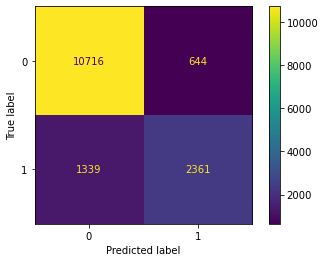


==== CLASSIFICATION REPORT ====

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     11360
           1       0.79      0.64      0.70      3700

    accuracy                           0.87     15060
   macro avg       0.84      0.79      0.81     15060
weighted avg       0.86      0.87      0.86     15060



In [10]:
model_13, predictions_13 = train_xgboost(X_train, y_train, X_test, y_test)

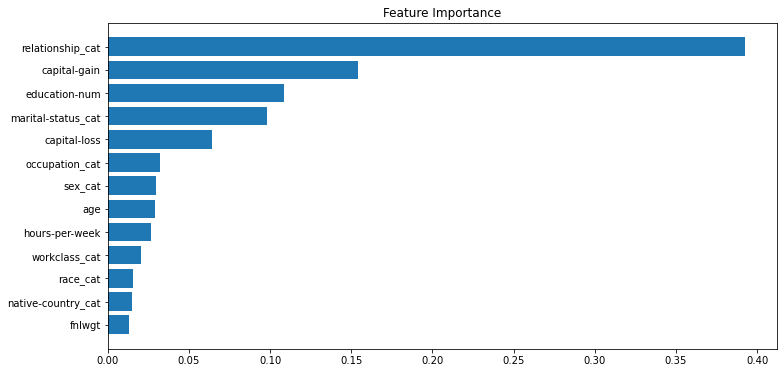

In [11]:
plot_features(model_13, X_test)

In [12]:
result = compute_result(y_test, predictions_13)
result

,Model,accuracy,precision,recall,f1
0,XGBoost,0.868327,0.785691,0.638108,0.704251


## There are a few features with the importance lower than 0.03. So we will remove them and train another model.

In [13]:
continuous_columns_for_training = ['age', 'education-num', 'capital-gain', 'hours-per-week', 'capital-loss']
category_columns_for_training = ['marital-status_cat', 'occupation_cat', 'relationship_cat']
columns_for_training = continuous_columns_for_training + category_columns_for_training
len(columns_for_training)

8

In [14]:
X_train = train_data[columns_for_training]
y_train = train_data['salary_label']
X_test = test_data[columns_for_training]
y_test = test_data['salary_label']

==== IMPORTANCES ====

age                   0.034382
education-num         0.124591
capital-gain          0.176511
hours-per-week        0.029148
capital-loss          0.062415
marital-status_cat    0.123673
occupation_cat        0.036494
relationship_cat      0.412785
dtype: float32

==== CONFUSION MATRIX ====


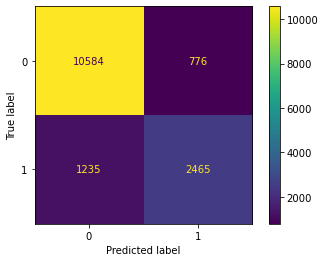


==== CLASSIFICATION REPORT ====

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     11360
           1       0.76      0.67      0.71      3700

    accuracy                           0.87     15060
   macro avg       0.83      0.80      0.81     15060
weighted avg       0.86      0.87      0.86     15060



In [15]:
model_8, predictions_8 = train_xgboost(X_train, y_train, X_test, y_test)

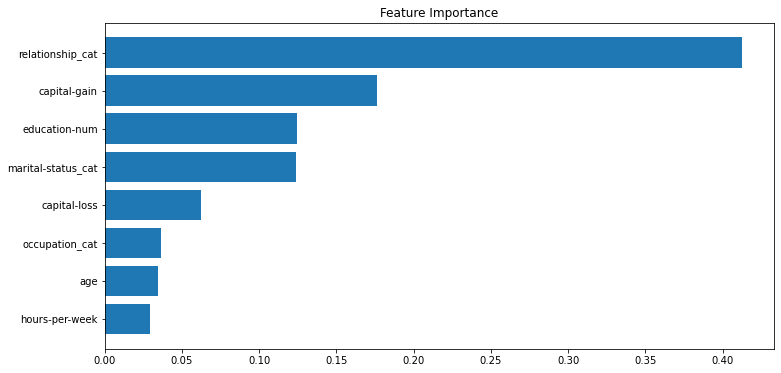

In [16]:
plot_features(model_8, X_test)

In [17]:
result = compute_result(y_test, predictions_8)
result

,Model,accuracy,precision,recall,f1
0,XGBoost,0.866467,0.760568,0.666216,0.710272


## We remove even more features (<0.07)

In [18]:
continuous_columns_for_training = ['education-num', 'capital-gain', 'capital-loss']
category_columns_for_training = ['marital-status_cat', 'occupation_cat', 'relationship_cat']
columns_for_training = continuous_columns_for_training + category_columns_for_training
print(len(columns_for_training))

X_train = train_data[columns_for_training]
y_train = train_data['salary_label']
X_test = test_data[columns_for_training]
y_test = test_data['salary_label']

6


==== IMPORTANCES ====

education-num         0.147873
capital-gain          0.146669
capital-loss          0.063693
marital-status_cat    0.147128
occupation_cat        0.046517
relationship_cat      0.448119
dtype: float32

==== CONFUSION MATRIX ====


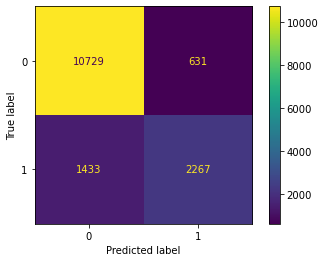


==== CLASSIFICATION REPORT ====

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     11360
           1       0.78      0.61      0.69      3700

    accuracy                           0.86     15060
   macro avg       0.83      0.78      0.80     15060
weighted avg       0.86      0.86      0.86     15060



In [19]:
model_6, predictions_6 = train_xgboost(X_train, y_train, X_test, y_test)

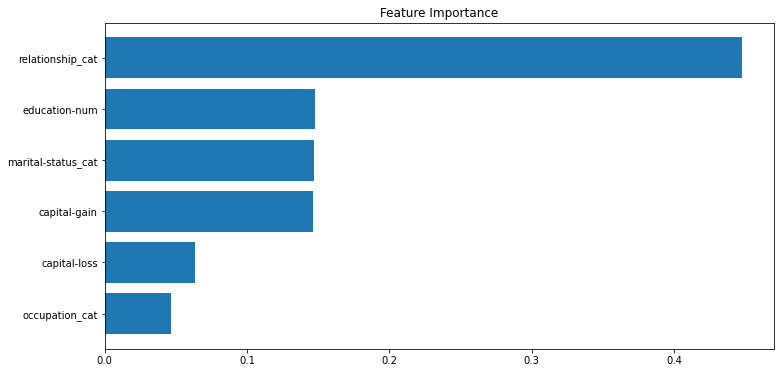

In [20]:
plot_features(model_6, X_test)

In [21]:
result = compute_result(y_test, predictions_6)
result

,Model,accuracy,precision,recall,f1
0,XGBoost,0.862948,0.782264,0.612703,0.687178


## We chose the model with the best result to predict test data


In [22]:
test_data = pd.read_csv("./data/processed_test.csv", delimiter = ',')
test_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,hours-per-week_cat,workclass_cat,education_cat,marital-status_cat,occupation_cat,relationship_cat,race_cat,sex_cat,native-country_cat,salary_label
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,...,2,2,1,4,6,3,2,1,37,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,3,2,11,2,4,0,4,1,37,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,...,2,1,7,2,10,0,4,1,37,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,2,2,15,2,6,0,2,1,37,1
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,...,2,2,0,4,7,1,4,1,37,0


In [23]:
continuous_columns_for_training = ['age', 'education-num', 'capital-gain', 'hours-per-week', 'capital-loss']
category_columns_for_training = ['marital-status_cat', 'occupation_cat', 'relationship_cat']
columns_for_training = continuous_columns_for_training + category_columns_for_training
len(columns_for_training)

X = test_data[columns_for_training]
y = test_data['salary_label']

In [24]:
predictions_test = model_8.predict(X)

In [25]:
result = compute_result(y, predictions_test)
result

,Model,accuracy,precision,recall,f1
0,XGBoost,0.866467,0.760568,0.666216,0.710272



==== CONFUSION MATRIX ====


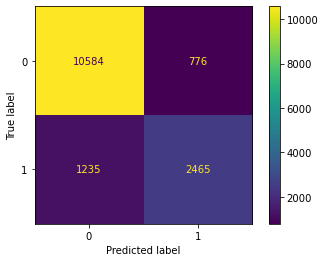

In [26]:
cm = confusion_matrix(y, predictions_test, labels=model_13.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_13.classes_)
print("\n==== CONFUSION MATRIX ====")
disp.plot()
plt.show()

# Rezultatul f1 obtinut pe datelte de test este de 0.710.